In [3]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [4]:
dataset = 'stock' #choose 'healthcare' or 'airquality'
datafolder = './save/stock_fold0_20230720_085603' # set the folder name
nsample = 100 # number of generated sample

path = datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length


qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

IndexError: index 6 is out of bounds for axis 0 with size 6

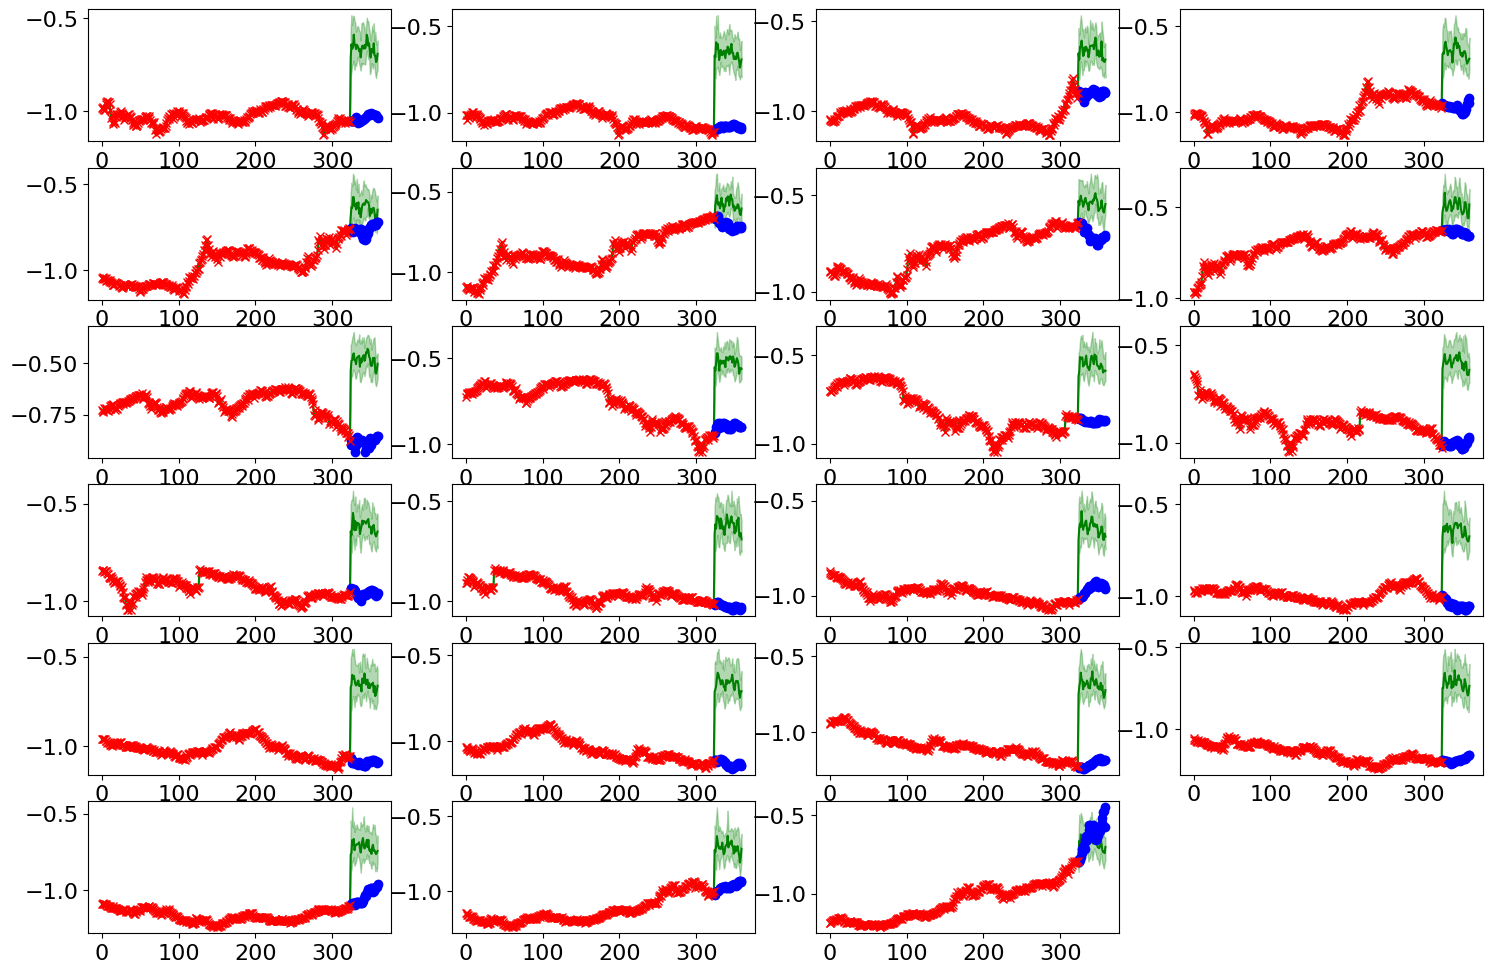

In [6]:
###stock###

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=6, ncols=4,figsize=(18, 12))
fig.delaxes(axes[-1][-1])

for k in range(samples.shape[0]):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[k,:,0], "y":all_evalpoint_np[k,:,0]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[k,:,0], "y":all_given_np[k,:,0]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][k,:,0], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[1][k,:,0],quantiles_imp[3][k,:,0],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')